# 1. Introducing Model Selection

* In the previous mission, `we worked to optimize our predictions by creating and selecting the features used to train our model.` The other half of the optimization puzzle is to `optimize the model itself— or more specifically, the algorithm used to train our model.`

* There are hundreds of different machine learning algorithms from which we can choose. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data— in this case our Kaggle competition.

**`The process of selecting the algorithm which gives the best predictions for your data is called model selection.`**

* To save time, we have saved the features we created in the previous mission as CSV files, `train_modified.csv` and `holdout_modified.csv`.

## TODO:
* Import train_modified.csv into a pandas dataframe and assign the result to train.
* Import holdout_modified.csv into a pandas dataframe and assign the result to holdout.

In [1]:
import pandas as pd

train=pd.read_csv('train_modified.csv')
holdout=pd.read_csv('holdout_modified.csv')

# 2. Training a Baseline Model

## TODO:
* Instantiate a linear_model.LogisticRegression class.
* Use the model_selection.cross_val_score() function to train and test a model assigning the result to scores, using:
* The LogisticRegression object you just created.
   * all_X and all_y as the X and y parameters
   * 10 folds.
* Calculate the mean of scores and assign the result to accuracy_lr.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

all_x = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr=LogisticRegression(solver='lbfgs')
scores=cross_val_score(lr,all_x,all_y,cv=10)

accuracy_lr=scores.mean()
accuracy_lr

0.8250025536261492

# 3. Training a Model using K-Nearest Neighbors

**`The k-nearest neighbors algorithm` finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.**

## TODO:
* Instantiate a neighbors.KNeighborsClassifier object, setting the n_neighbors argument to 1.
* Use the model_selection.cross_val_score() function to train and test a model assigning the result to scores, using:
* The KNeighborsClassifier object you just created.
  * all_X and all_y as the the X and y parameters.
  * 10 folds.
* Calculate the mean of scores and assign the result to accuracy_knn.

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=1)
scores=cross_val_score(knn,all_x,all_y,cv=10)
accuracy_knn=scores.mean()
accuracy_knn

0.7857382816933379

# 4. Exploring Different K Values

* Besides pure model selection, we can vary the settings of each model— for instance the value of k in our k-nearest neighbors model. This is called **`hyperparameter optimization`.**

* We can use a loop and Python's inbuilt range() class to iterate through different values for k and calculate the accuracy score for each different value. We will only want to test odd values for k to avoid ties, where both 'survived' and 'died' outcomes would have the same number of neighbors.

## TODO:
* Use a for loop and the range class to iterate over odd values of k from 1-49, and in each iteration:
  * Instantiate a KNeighborsClassifier object with the value of k for the n_neighbors argument.
  * Use cross_val_score to create a list of scores using the newly created KNeighborsClassifier object, using all_X, all_y, and    cv=10 as the arguments.
  * Calculate the mean of the list of scores.
  * Add the mean of the scores to the dictionary knn_scores, using k for the key.
* Use the plot_dict() helper function to plot the knn_scores dictionary.

In [4]:
import matplotlib.pyplot as plt 
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),ylim=(0.78,0.83),rot=0)
    print(pd.Series(dictionary))
    plt.show()

In [5]:
knn_scores={}
for k in range(1,50,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,all_x,all_y,cv=10)
    knn_scores[k]=scores.mean()

1     0.785738
3     0.804841
5     0.822718
7     0.820459
9     0.821582
11    0.811507
13    0.817125
15    0.811494
17    0.814940
19    0.823891
21    0.817099
23    0.819334
25    0.815963
27    0.810358
29    0.800245
31    0.803629
33    0.804727
35    0.797960
37    0.793515
39    0.794665
41    0.792430
43    0.798048
45    0.796899
47    0.794664
49    0.784601
dtype: float64


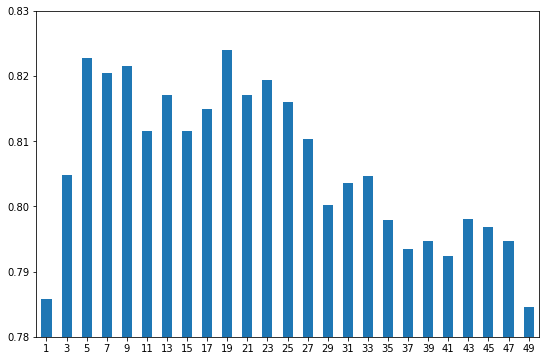

In [6]:
plot_dict(knn_scores)

# 5. Automating Hyperparameter Optimization with Grid Search

|Model	|Cross-validation score|	Kaggle score|
|-------|----------------------|----------------|
|Previous best Kaggle score|	82.3%|	78.0%|
|Logistic regression baseline|	82.4%|	|
|K-nearest neighbors, k == 1|	78.6%||	
|K-nearest neighbors,k == 19|	82.4%||

**The technique we just used is called `grid search - we train a number of models across a 'grid' of values and then searched for the model that gave us the highest accuracy`.**

* Scikit-learn has a class to perform grid search, model_selection.GridSearchCV(). The 'CV' in the name indicates that we're `performing both grid search and cross validation at the same time.`

* Our final step is to print the `GridSearchCV.best_params_` and `GridSearchCV.best_score_` attributes to retrieve the parameters of the best-performing model, and the score it achieved.

## TODO:
* Instantiate a KNeighborsClassifier object.
* Instantiate a GridSearchCV object, using:
  * The KNeighborsClassifier object you just created as the first (unnamed) argument.
  * The hyperparameters dictionary for the param_grid.
  * A cv of 10.
* Fit the GridSearchCV object using all_X and all_y.
* Assign the parameters of the best performing model to best_params.
* Assign the score of the best performing model to best_score.

In [7]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn=KNeighborsClassifier()
grid=GridSearchCV(knn,param_grid=hyperparameters,cv=10)
grid.fit(all_x,all_y)
best_params=grid.best_params_
best_score=grid.best_score_
best_score

0.8282828282828283

In [8]:
best_params

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

# 6. Submitting K-Nearest Neighbors Predictions to Kaggle

* We can use the GridSearchCV.best_estimator_ attribute to retrieve a trained model with the best-performing hyperparameters. This code:

`best_knn = grid.best_estimator_`

is equivalent to this code where we manually specify the hyperparameters and train the model:

`best_knn = KNeighborsClassifier(p=1,algorithm='brute',n_neighbors=5,
                     weights='uniform')
best_knn.fit(all_X,all_y)`

## TODO:
* Make predictions on the data from holdout_no_id using the best_knn model, and assign the result to holdout_predictions.
* Create a dataframe submission with two columns:
  * PassengerId, with the values from the PassengerId column of the holdout dataframe.
  * Survived, with the values from holdout_predictions.
* Use the DataFrame.to_csv method to save the submission dataframe to the filename submission_1.csv.

In [9]:
hold_no_id=holdout.drop(['PassengerId'],axis=1)
best_knn=grid.best_estimator_
holdout_predictions=best_knn.predict(hold_no_id)
submission=pd.DataFrame({'PassengerId':holdout['PassengerId'],'Survived':holdout_predictions})
submission.to_csv('submission_1.csv',index=False)

# 7. Introducing Random Forests

* Random forests is a specific type of decision tree algorithm. 

* Decision tree algorithms attempt to build the most efficient decision tree based on the training data, and then use that tree to make future predictions.
* Scikit-learn contains a class for classification using the random forest algorithm, `ensemble.RandomForestClassifier`

## TODO:
* Instantiate a RandomForestClassifier object, setting the random_state parameter to 1.
* Use the cross_val_score() function to generate a set of scores and assign the result to scores, using:
  * The RandomForestClassifier object you just created as the estimator
  * all_X and all_y for the train and test data
  * A cv value of 10
* Calculate the mean of scores and assign the result to accuracy_rf

In [10]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=1)
scors=cross_val_score(rfc,all_x,all_y,cv=10)
accuracy_rf=scores.mean()
accuracy_rf

0.7846013505844966

# 8. Tuning our Random Forests Model with GridSearch

## TODO:
* Instantiate a RandomForestClassifier object, setting the random_state parameter to 1.
* Instantiate a GridSearchCV object, using:
  * The RandomForestClassifier object you just created as the first (unnamed) argument.
  * A dictionary of hyperparameters that matches the list above for the param_grid argument
  * A cv of 10.
  * Fit the GridSearchCV object using all_X or all_y.
* Assign the parameters of the best performing model to best_params
* Assign the score of the best performing model to best_score.

In [11]:
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]}

clf=RandomForestClassifier(random_state=1)
grid=GridSearchCV(clf,param_grid=hyperparameters,cv=10)
grid.fit(all_x,all_y)
best_params=grid.best_params_
best_score=grid.best_score_
best_score

0.8428731762065096

# 9. Submitting Random Forest Predictions to Kaggle

## TODO:
* Assign the best performing model from the GridSearchCV object grid to best_rf.
* Make predictions on the data from holdout_no_id using the best_rf model, and assign the result to holdout_predictions.
* Create a dataframe submission with two columns:
  * PassengerId, with the values from the PassengerId column of the holdout dataframe.
  * Survived, with the values from holdout_predictions.
* Use the DataFrame.to_csv method to save the submission dataframe to the filename submission_2.csv.

In [12]:
best_rf=grid.best_estimator_

In [13]:
holdout_predictions=best_rf.predict(hold_no_id)

In [14]:
submission=pd.DataFrame({'PassengerId':holdout['PassengerId'],'Survived':holdout_predictions})

In [15]:
submission.to_csv('submission_2.csv',index=False)

## Improved score summary


|Model|	Cross-validation score	|Kaggle score|
|--------------------------|----------|-------|
|Previous best Kaggle score|	82.3%|	78.0%|
|Logistic regression baseline|	82.4%|	-|
|K-nearest neighbors, k == 1	|78.6%|- |	
|K-nearest neighbors, k == 19|	82.4%	|-|
|K-nearest neighbors, best model from grid search|	82.8%	|75.6%|
|Random forests, default hyperparameters|	80.7%	|-|
|Random forests, best model from grid search|	84.3%|	77.1%|